In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from time import time

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS
from pyro.distributions import constraints
from pyro.contrib.autoguide import AutoDiagonalNormal

from data_proc import load_raw_data, processData, transform_data, split_and_prep_data


pyro.enable_validation(True)

# Questions for Gurpreet
- We can use observed dummy/categorical variables, correct?
- Seems our data might fit a Zero-inflated poisson better, but how should we interpret/should we predict the gate, too (e.g. with a logit/probit)?
- Should a log link function on a poisson regression approximate a pareto distribution?

# Complete Level Model
Here, we will model each post as coming from one of four types, one subreddit, and being about one story.

# Data

First, we load the Reddit datasets

In [2]:
comments, corrections, news = load_raw_data()

### Process and Unpack Data

In [3]:
data_tuple, lookup_tuple, label_tuple = processData(news + corrections, comments, minutes=60)

In [4]:
original_p_data, t_data, s_data, r_data, y = data_tuple
p_types, p_stories, p_subreddits = lookup_tuple
countries, authors, story_claim_titles, subreddits = label_tuple

p_data variables (in order):

0. bias
1. comment_length_avg
2. normalized comment_upvotes_avg
3. num_unique_comment_authors
4. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t_data variables (in order):

0. bias
1. Real News Dummy
2. Fake News Dummy
3. Correction on Real News Dummy
4. Correction on Fake News Dummy

s_data variables:

0. bias
1. country dummies (multiple may be "on")
2. author dummies

r_data variables:

0. bias
1. subreddit dummies

### Data Transformations

In [5]:
# before we change anything, save the original p_data
p_data = transform_data(original_p_data)

In [6]:
# Split into Test and Train datasets
train_data, test_data, unsplit_data = split_and_prep_data(p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits, train_frac=0.7)
p_data_train, y_train, p_types_train, p_stories_train, p_subreddits_train = train_data
p_data_test, y_test, p_types_test, p_stories_test, p_subreddits_test = test_data
t_data, s_data, r_data = unsplit_data

-----

# Modeling

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + eta_01 silliness_t + nu_0t

phi_1t = eta_10 * bias + eta_11 silliness_t + nu_1t

In [7]:
def model(p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits):
    coef_scale_prior = 0.1
        
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    num_stories, num_s_indeps = s_data.shape
    num_subreddits, num_r_indeps = r_data.shape
    
    # type priors
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps), dtype=torch.float64)
    alpha_scale = coef_scale_prior * torch.ones((num_p_indeps, num_t_indeps), dtype=torch.float64)
    
    # story priors
    beta_loc = torch.zeros((num_p_indeps, num_s_indeps), dtype=torch.float64)
    beta_scale = coef_scale_prior * torch.ones((num_p_indeps, num_s_indeps), dtype=torch.float64)
    
    # type priors
    tau_loc = torch.zeros((num_p_indeps, num_r_indeps), dtype=torch.float64)
    tau_scale = coef_scale_prior * torch.ones((num_p_indeps, num_r_indeps), dtype=torch.float64)
    
    
    
    with pyro.plate("p_indep", num_p_indeps, dim=-2) as pi:
        
        # Type Level
        with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
            eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))
    
        with pyro.plate("type", num_types, dim=-1) as t:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi_dist = dist.Normal(phi_loc, coef_scale_prior)
            phi = pyro.sample("phi", phi_dist)
            
        # Story Level

        with pyro.plate("s_indep", num_s_indeps, dim=-1) as si:
            beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale))
    
        with pyro.plate("story", num_stories, dim=-1) as s:
            theta_loc = torch.matmul(beta, s_data[s,:].T) # (num_p_indeps, num_s_indeps) x (num_s_indeps, num_stories)

            theta_dist = dist.Normal(theta_loc, coef_scale_prior)
            theta = pyro.sample("theta", theta_dist)
    
        # Subreddit Level

        with pyro.plate("r_indep", num_r_indeps, dim=-1) as ri:
            tau = pyro.sample("tau", dist.Normal(tau_loc, tau_scale))
    
        with pyro.plate("subreddit", num_subreddits, dim=-1) as r:
            rho_loc = torch.matmul(tau, r_data[r,:].T) # (num_p_indeps, num_r_indeps) x (num_r_indeps, num_subreddits)

            rho_dist = dist.Normal(rho_loc, coef_scale_prior)
            rho = pyro.sample("rho", rho_dist)
            
    # Gate
    
    with pyro.plate("type2", num_types, dim=-1):
        gate = pyro.sample("gate", dist.Beta(torch.ones((num_types,), dtype=torch.float64),
                                               torch.ones((num_types,), dtype=torch.float64),
                                              ))
    
#     gate = pyro.sample("gate", dist.Beta(2.*torch.ones((1,), dtype=torch.float64),
#                                          2.*torch.ones((1,), dtype=torch.float64),
#                                         ))
    
    
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, dim=-1) as p:    
        t = p_types[p]
        s = p_stories[p]
        r = p_subreddits[p]

        # indep vars for this post
        indeps = p_data[p,:]
        
        t_coefs = phi[:,t] # (num_p_indeps,num_posts)
        s_coefs = theta[:,s] # (num_p_indeps,num_posts)
        r_coefs = rho[:,r] # (num_p_indeps,num_posts)
        
        type_level_products = torch.mul(t_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)
        story_level_products = torch.mul(s_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)
        subreddit_level_products = torch.mul(r_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = (subreddit_level_products + type_level_products + story_level_products).sum(dim=0)  # (num_p_indeps, num_posts).sum(over indeps)
        
        # sample
        if y is None:
            pyro.sample("obs", dist.ZeroInflatedPoisson(rate=torch.exp(mu), gate=gate.flatten()[t]), obs=y)
        else:
            pyro.sample("obs", dist.ZeroInflatedPoisson(rate=torch.exp(mu), gate=gate.flatten()[t]), obs=y[p])


In [72]:
def guide(p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits):
    coef_scale_prior = 0.1
    
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    num_stories, num_s_indeps = s_data.shape
    num_subreddits, num_r_indeps = r_data.shape
    
    # define a prior for our regression variables
    
    # type level
    # The zeros and ones are the "alpha" in the graphical model from the proposal
    eta_loc = pyro.param("eta_loc", 
                         torch.zeros((num_p_indeps, num_t_indeps), dtype=torch.float64))
    eta_scale = pyro.param("eta_scale", 
                           coef_scale_prior * torch.ones((num_p_indeps, num_t_indeps), dtype=torch.float64), 
                           constraint=constraints.positive)
    
    phi_scale = pyro.param("phi_scale", 
                           coef_scale_prior * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all types.
    # story level
    beta_loc = pyro.param("beta_loc", 
                          torch.zeros((num_p_indeps, num_s_indeps), dtype=torch.float64))
    beta_scale = pyro.param("beta_scale", 
                            coef_scale_prior * torch.ones((num_p_indeps, num_s_indeps), dtype=torch.float64), 
                            constraint=constraints.positive)
            
    theta_scale = pyro.param("theta_scale", 
                           coef_scale_prior * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all stories.
    
    # subreddit level
    tau_loc = pyro.param("tau_loc", 
                          torch.zeros((num_p_indeps, num_r_indeps), dtype=torch.float64))
    tau_scale = pyro.param("tau_scale", 
                            coef_scale_prior * torch.ones((num_p_indeps, num_r_indeps), dtype=torch.float64), 
                            constraint=constraints.positive)
            
    rho_scale = pyro.param("rho_scale", 
                           coef_scale_prior * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all subreddits.
            
    with pyro.plate("p_indep", num_p_indeps, dim=-2) as pi:
        
        # type level
        
        with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
            eta = pyro.sample("eta", dist.Normal(eta_loc, eta_scale))
    
        with pyro.plate("type", num_types, dim=-1) as t:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))
            
        # story level

        with pyro.plate("s_indep", num_s_indeps, dim=-1) as si:
            beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale))
    
        with pyro.plate("story", num_stories, dim=-1) as s:
            theta_loc = torch.matmul(beta, s_data[s,:].T) # (num_p_indeps, num_s_indeps) x (num_s_indeps, num_stories)

            theta = pyro.sample("theta", dist.Normal(theta_loc, theta_scale))
    
        # subreddit level

        with pyro.plate("r_indep", num_r_indeps, dim=-1) as ri:
            tau = pyro.sample("tau", dist.Normal(tau_loc, tau_scale))
    
        with pyro.plate("subreddit", num_subreddits, dim=-1) as r:
            rho_loc = torch.matmul(tau, r_data[r,:].T) # (num_p_indeps, num_r_indeps) x (num_r_indeps, num_subreddits)

            rho = pyro.sample("rho", dist.Normal(rho_loc, rho_scale))
    
    # Gate 
    
    gate_alpha = pyro.param("gate_alpha", 2.*torch.ones((num_types,), dtype=torch.float64), constraint=constraints.positive)
    gate_beta = pyro.param("gate_beta", 2.*torch.ones((num_types,), dtype=torch.float64), constraint=constraints.positive)
    with pyro.plate("type2", num_types, dim=-1):
        gate = pyro.sample("gate", dist.Beta(gate_alpha,gate_beta))
    
    
    return eta, phi, beta, theta

In [56]:
pyro.clear_param_store()

## Traces (to double check tensor shapes)

# Inference

## SVI

In [57]:
SUBSAMPLE = False

svi = SVI(model,
          guide,
          optim.ClippedAdam({"lr": 1e-2}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 10000
losses = np.zeros((num_iters,))

start_time = time()

for i in range(num_iters):
    if SUBSAMPLE:
        elbo = svi.step(p_data_train[:250], 
                        t_data, 
                        s_data, 
                        r_data, 
                        y_train[:250], 
                        p_types_train[:250], 
                        p_stories_train[:250], 
                        p_subreddits_train[:250])
    else:
        elbo = svi.step(p_data_train, 
                        t_data, 
                        s_data, 
                        r_data, 
                        y_train, 
                        p_types_train, 
                        p_stories_train, 
                        p_subreddits_train)
    losses[i] = elbo
    if i % 100 == 99:
        elapsed = time() - start_time
        remaining = (elapsed / (i+1)) * (num_iters - i)
        print(f"Iter {i+1}/{num_iters}"
              "\t||\t"
              f"Elbo loss: {elbo:.2e}"
              "\t||\t"
              f"Time Elapsed: {int(elapsed) // 60:02}:{int(elapsed) % 60:02}"
              "\t||\t"
              f"Est Remaining: {int(remaining) // 60:02}:{int(remaining) % 60:02}", end="\r", flush=True)

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/pyro/distributions/util.py:180: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif reversed_shape[i] == 1 and not strict:
/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/pyro/distributions/util.py:182: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif reversed_shape[i] != size and (size != 1 or strict):


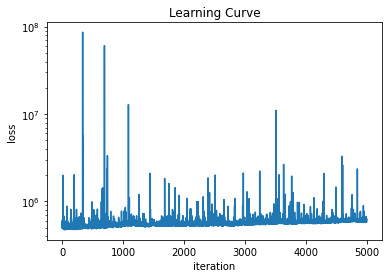

In [109]:
plt.plot(range(len(losses[5000:])), np.array(losses[5000:]))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

----

In [60]:
import pyro.poutine as poutine

In [61]:
trace = poutine.trace(model).get_trace(p_data_train, 
                                       t_data, 
                                       s_data, 
                                       r_data, 
                                       y_train, 
                                       p_types_train, 
                                       p_stories_train,
                                       p_subreddits_train,
                                      )
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

 Trace Shapes:          
  Param Sites:          
 Sample Sites:          
  p_indep dist         |
         value       5 |
      log_prob         |
  t_indep dist         |
         value       5 |
      log_prob         |
      eta dist 5     5 |
         value 5     5 |
      log_prob 5     5 |
     type dist         |
         value       4 |
      log_prob         |
      phi dist 5     4 |
         value 5     4 |
      log_prob 5     4 |
  s_indep dist         |
         value     235 |
      log_prob         |
     beta dist 5   235 |
         value 5   235 |
      log_prob 5   235 |
    story dist         |
         value    7763 |
      log_prob         |
    theta dist 5  7763 |
         value 5  7763 |
      log_prob 5  7763 |
  r_indep dist         |
         value    1334 |
      log_prob         |
      tau dist 5  1334 |
         value 5  1334 |
      log_prob 5  1334 |
subreddit dist         |
         value    1333 |
      log_prob         |
      rho dist 5  1333 |


In [62]:
trace = poutine.trace(guide).get_trace(p_data_train, 
                                       t_data, 
                                       s_data, 
                                       r_data, 
                                       y_train, 
                                       p_types_train, 
                                       p_stories_train,
                                       p_subreddits_train,
                                      )
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

 Trace Shapes:            
  Param Sites:            
       eta_loc      5    5
     eta_scale      5    5
     phi_scale      5    1
      beta_loc      5  235
    beta_scale      5  235
   theta_scale      5    1
       tau_loc      5 1334
     tau_scale      5 1334
     rho_scale      5    1
    gate_alpha           4
     gate_beta           4
 Sample Sites:            
  p_indep dist           |
         value      5    |
      log_prob           |
  t_indep dist           |
         value      5    |
      log_prob           |
      eta dist 5    5    |
         value 5    5    |
      log_prob 5    5    |
     type dist           |
         value      4    |
      log_prob           |
      phi dist 5    4    |
         value 5    4    |
      log_prob 5    4    |
  s_indep dist           |
         value    235    |
      log_prob           |
     beta dist 5  235    |
         value 5  235    |
      log_prob 5  235    |
    story dist           |
         value   7763    |
 

## MCMC (NUTS)

In [63]:
#kernel = NUTS(model_no_subsample)

#num_iters = 1000
#warmup_steps = 500
#mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
#mcmc.run(p_data_train[:100], p_types_train[:100], t_data, y_train[:100])

In [64]:
#posterior_samples = mcmc.get_samples()

In [65]:
#eta_means = posterior_samples["eta"].mean(dim=0)
#eta_means

In [66]:
#phi_means = posterior_samples["phi"].mean(dim=0)
#phi_means

# Evaluation

Recall:

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

Check the fit

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + nu_0t

phi_1t = eta_10 * bias + nu_1t

In [67]:
labels = np.array(["Factual News", "Fake News", "Review of Factual News", "Review of Fake News"])

<ipython-input-68-25465b7dd52a>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)
<ipython-input-68-25465b7dd52a>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_coefs = torch.tensor(theta[:,s]) # (num_p_indeps,num_posts)
<ipython-input-68-25465b7dd52a>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_coefs = torch.tensor(rho[:,r]) # (num_p_indeps,num_posts)


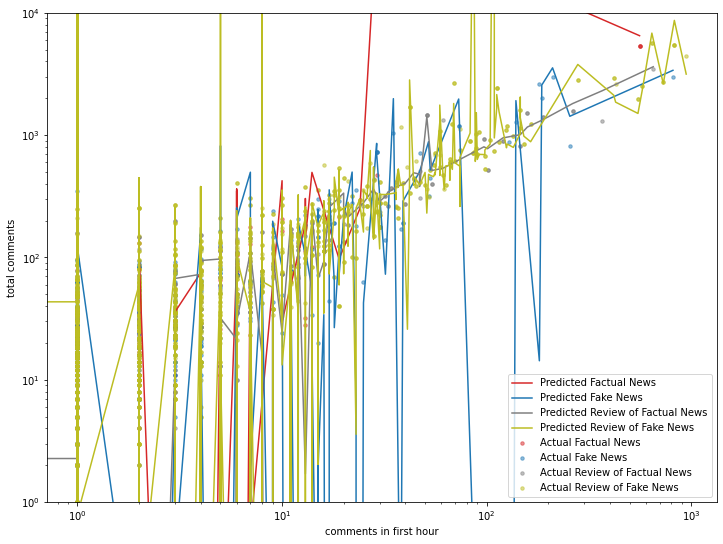

In [68]:
indep = 4

indep_dict = {
    1: "avg cmt length",
    2: "avg upvotes",
    3: "num authors",
    4: "comments in first hour",
}
# indep_dict = {
#     1: "comments in first hour",
# }

use_MCMC = False

if use_MCMC:
    eta_loc = eta_means
    beta_loc = beta_means
    tau_loc = gamma_means
else:
    eta_loc = pyro.param('eta_loc').detach()
    beta_loc = pyro.param('beta_loc').detach()
    tau_loc = pyro.param('tau_loc').detach()

phi = torch.matmul(eta_loc, t_data.T)
theta = torch.matmul(beta_loc, s_data.T)
rho = torch.matmul(tau_loc, r_data.T)

t = torch.Tensor(p_types).long()
s = torch.Tensor(p_stories).long()
r = torch.Tensor(p_subreddits).long()

indeps = torch.tensor(p_data)

t_coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)
s_coefs = torch.tensor(theta[:,s]) # (num_p_indeps,num_posts)
r_coefs = torch.tensor(rho[:,r]) # (num_p_indeps,num_posts)

mu = (torch.mul(t_coefs, indeps.T) 
      + torch.mul(s_coefs, indeps.T) 
      + torch.mul(r_coefs, indeps.T)
     ).sum(dim=0)

y_pred = np.exp(mu)


plt.figure(figsize=(12,9))

types = np.unique(p_types)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_choices = np.random.choice(colors, size=len(types), replace=False)



for i, t in enumerate(types):
#     if t == 0:
        y_pred_t = y_pred[p_types == t]
        y_t = 1 * y[p_types == t]
        x_t = original_p_data[p_types == t,indep]
        
        sorted_indices = np.argsort(x_t)

        type_label = labels[int(t)]

        color = color_choices[i]
        plt.scatter(x_t, y_t, alpha=0.5, s=12, c=color, label=f"Actual {type_label}")
        plt.plot(x_t[sorted_indices], y_pred_t[sorted_indices], c=color, label=f"Predicted {type_label}")
    
# plt.plot(np.array(p_data[:,indep]), np.array(y_pred_mcmc), c='tab:green', label=f'MCMC: {phi_means[0]}, {phi_means[1]}') # MCMC
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylim(1,1e4)
# plt.xlim(0,10)
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

----

Generate posterior predictive samples

In [75]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_train, 
                                      t_data, 
                                      s_data, 
                                      r_data, 
                                      None, 
                                      p_types_train, 
                                      p_stories_train,
                                      p_subreddits_train,
                                     ).items()}

In [76]:
svi_az = az.convert_to_inference_data({'obs': svi_samples['obs']}, group='posterior_predictive')

In [77]:
svi_az.add_groups({'posterior': {'phi': svi_samples['phi'], 
                                 'eta': svi_samples['eta'], 
                                 'theta': svi_samples['theta'], 
                                 'beta': svi_samples['beta'],
                                 'tau': svi_samples['tau'],
                                 'rho': svi_samples['rho']}})

In [78]:
svi_az.add_groups({'observed_data': {'obs': y_train.reshape(1,1,-1)}})

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/data/inference_data.py:790: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


---

Posterior distribution over latent variables:

In [24]:
# az.plot_trace(svi_az, compact=True)
# plt.show()

In [84]:
az.plot_trace(svi_az.posterior['phi'], compact=False)
plt.show()

KeyboardInterrupt: 

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/plots/plot_utils.py:477: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (46) in plot_posterior, generating only 40 plots
  warnings.warn(


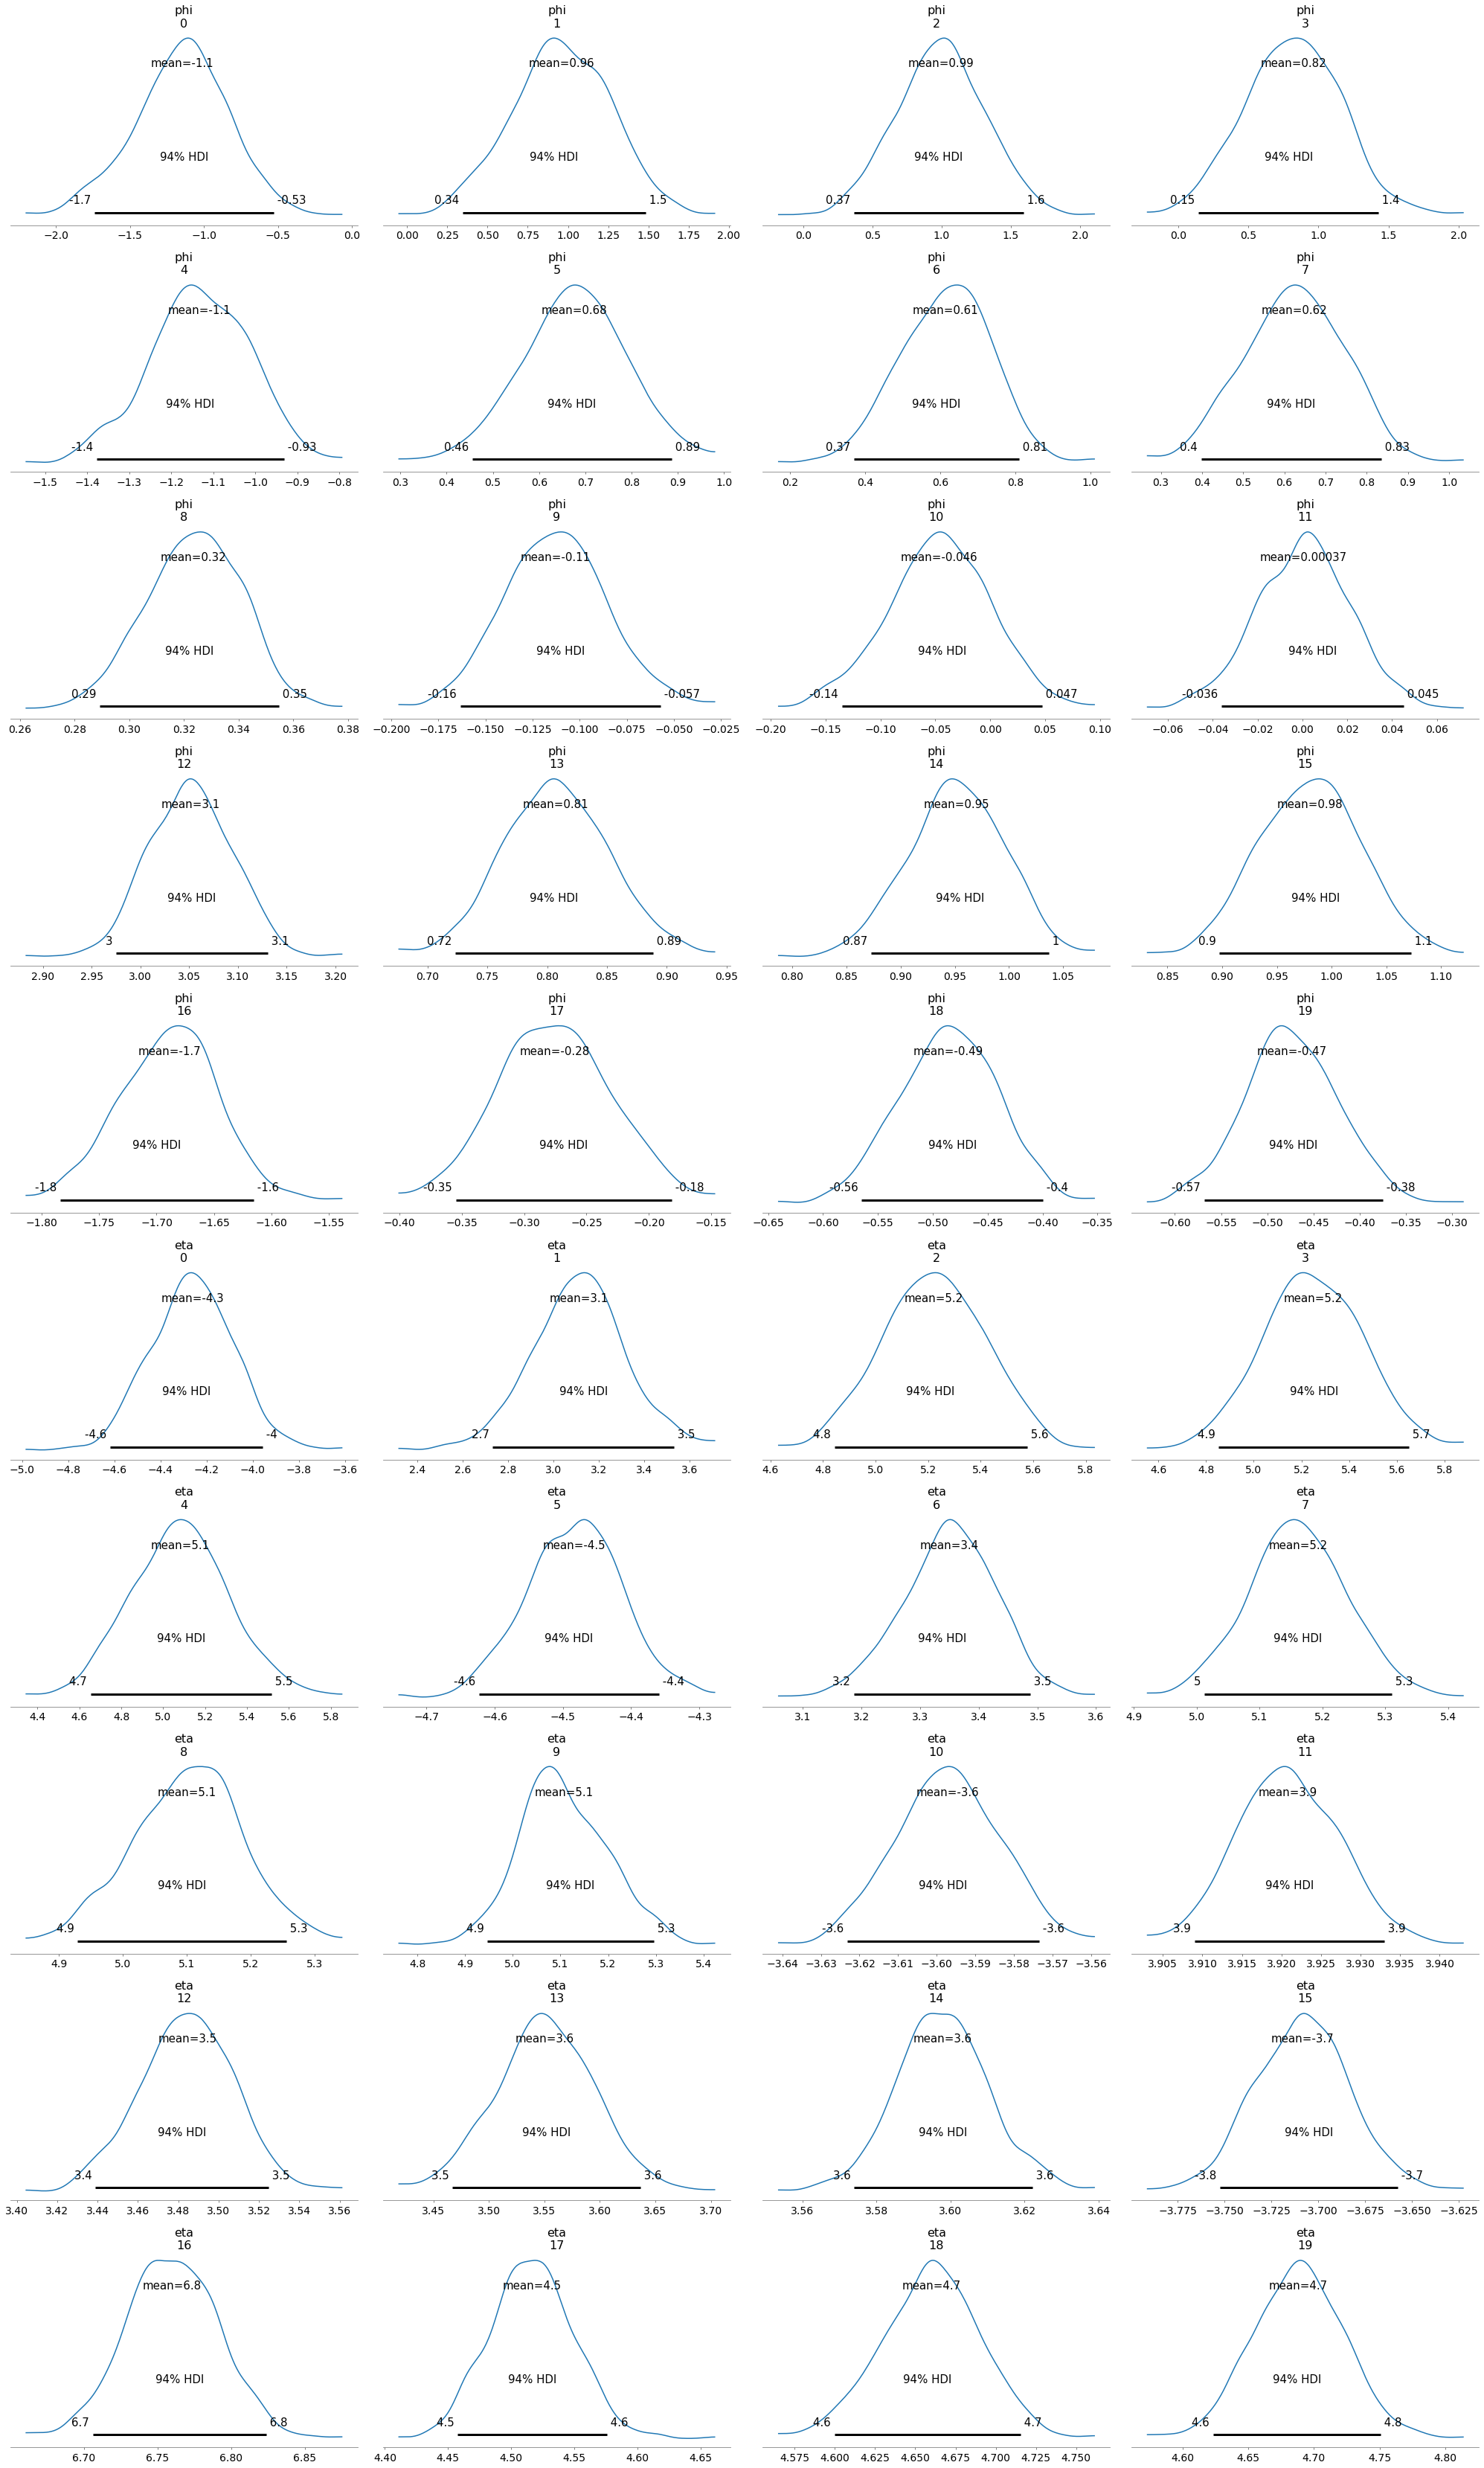

In [120]:

az.plot_posterior(svi_az)
plt.show()

---

Posterior predictive checks

In [79]:
y_train = np.array(y_train)
uniq = np.unique(y_train).astype(int)
cum_density = []
densities = []

for i in uniq:
    density = (y_train <= i).mean()
    cum_density.append((i, density))
    densities.append((i, (y_train == i).mean()))
    
cum_density = np.array(cum_density)
densities = np.array(densities)

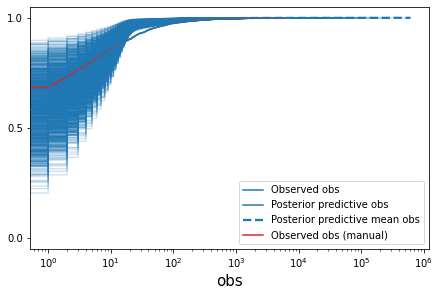

In [80]:
az.plot_ppc(svi_az, kind='cumulative')
plt.xscale('log')
plt.plot(cum_density[:,0], cum_density[:,1], c='tab:red', label='Observed obs (manual)')
# plt.yscale('log')
#plt.xlim(0, 400)
#plt.ylim(0, 0.05)
plt.set_cmap('jet')
plt.legend(loc="lower right")
plt.show()

- Max value

In [81]:
np.max(y_train)

5616.0

In [82]:
np.max(svi_samples['obs'])

612191.0

In [83]:
np.mean(y_train)

18.04499123547361

In [84]:
np.mean(svi_samples['obs'])

11.184964487437512

In [100]:
np.percentile(y_train, 90)

19.0

In [86]:
np.percentile(svi_samples['obs'], 90)

13.0

In [87]:
np.min(y_train)

0.0

In [88]:
np.min(svi_samples['obs'])

0.0

In [89]:
maxes = np.max(svi_samples['obs'].reshape(1000,-1), axis=1)

In [90]:
np.sum(maxes > np.max(y_train))

900

In [91]:
np.log(np.max(y_train))

8.633374945705647

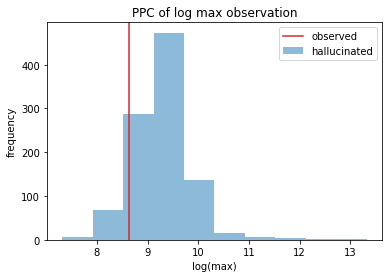

In [92]:
plt.hist(np.log(maxes), alpha=0.5, label="hallucinated")
plt.axvline(np.log(np.max(y_train)), color="tab:red", label="observed")
plt.title("PPC of log max observation")
plt.xlabel("log(max)")
plt.ylabel("frequency")
plt.legend()
plt.show()

- % obs that are 0

In [93]:
(y_train == 0).mean()

0.5833928455495683

In [94]:
(svi_samples['obs'] == 0).mean()

0.5888125689800688

- % obs that are less than 10

In [95]:
(y_train < 10).mean()

0.8489255339868856

In [96]:
(svi_samples['obs'] < 10).mean()

0.8405980653119522

- % obs that are above 1k

In [97]:
(y_train > 1000).mean()

0.0034408881386742843

In [98]:
(svi_samples['obs'] > 1000).mean()

0.0014371875608647667

# Why Pareto?
Our distribution of total comments follows a power law.

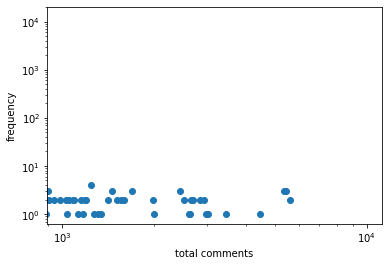

In [46]:
max_ct = np.max(y)
unique, counts = np.unique(y, return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("total comments")
plt.ylabel("frequency")
plt.show()

Fake news: expect relatively flatter (more with lots, fewer with few!)

Reviews: expect steeper (fewer comments very common)

Note that our first hour comments are also distributed similarly.

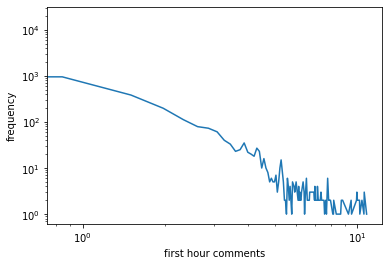

In [48]:
max_ct = np.max(p_data[:,1])
unique, counts = np.unique(p_data[:,1], return_counts=True)
plt.plot(unique, counts)
plt.yscale("log")
plt.xscale("log")
#plt.xlim(1, 10000)
plt.xlabel("first hour comments")
plt.ylabel("frequency")
plt.show()

In [ ]:
p_data[:,1].shape